In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt

ROOT = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
PROCESSED_DATA_DIR = os.path.join(ROOT, 'data/processed')

In [ ]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

rows = []

for fname in sorted(os.listdir(PROCESSED_DATA_DIR)):
    if not fname.endswith('.csv'):
        continue
    fpath = os.path.join(PROCESSED_DATA_DIR, fname)
    df = pd.read_csv(fpath)
    if "OCR_noise_ratio" not in df.columns:
        continue
    
    desc = df["OCR_noise_ratio"].describe(percentiles=percentiles)
    rows.append({
        "file": fname,
        "count": int(desc["count"]),
        "mean": desc["mean"],
        "std": desc["std"],
        "min": desc["min"],
        "p10": desc["10%"],
        "p25": desc["25%"],
        "p50": desc["50%"],
        "p75": desc["75%"],
        "p90": desc["90%"],
        "max": desc["max"],
    })

stats_df = pd.DataFrame(rows)

NameError: name 'os' is not defined

除books外，其他结果看起来不错。先用整体数据跑一次模型

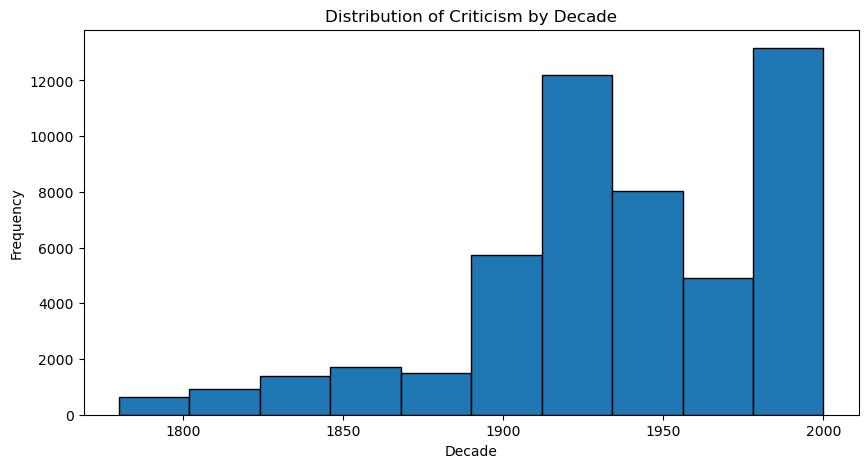

In [33]:
MERGED_DATA_PATH = os.path.join(ROOT, 'data/merged_data.csv')

merged_df = pd.read_csv(MERGED_DATA_PATH)

# distribution of the amount of criticism by decade
plt.figure(figsize=(10,5))
plt.hist(merged_df['Decade'], bins=10, edgecolor='black')
plt.title('Distribution of Criticism by Decade')
plt.xlabel('Decade')
plt.ylabel('Frequency')
plt.show()

### 2. Language Evolution: Text Length over Time

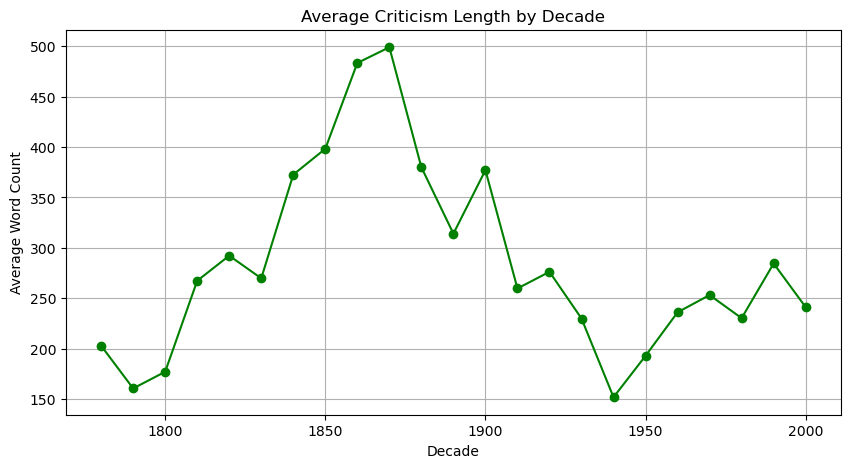

In [34]:
# Calculate word count for each text
merged_df['word_count'] = merged_df['Processed_text'].apply(lambda x: len(str(x).split()))

# Group by Decade and calculate mean word count
length_by_decade = merged_df.groupby('Decade')['word_count'].mean().sort_index()

# Plot
plt.figure(figsize=(10, 5))
length_by_decade.plot(kind='line', marker='o', color='green')
plt.title('Average Criticism Length by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Word Count')
plt.grid(True)
plt.show()

### 3. Language Evolution: Vocabulary Changes

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

# --- Step 1: Analyze global top words to identify noise ---
print("Top 20 frequent words in the entire dataset (using only standard English stop words):")
vec_global = CountVectorizer(stop_words='english', max_features=20)
X_global = vec_global.fit_transform(merged_df['Processed_text'].astype(str))
words_global = vec_global.get_feature_names_out()
counts_global = X_global.sum(axis=0).A1
sorted_global = sorted(zip(words_global, counts_global), key=lambda x: x[1], reverse=True)
print([w[0] for w in sorted_global])
print("\nThese words are too generic (e.g., 'mr', 'play', 'music'), so we will add them to stop words.\n")
print("-" * 50 + "\n")

# --- Step 2: Define custom stop words and analyze by decade ---
def get_top_words_by_decade(df, n_top=10):
    # Filter out invalid decades if necessary
    decades = sorted([d for d in df['Decade'].unique() if pd.notna(d)])
    evolution_data = {}
    
    # Custom stop words relevant to the domain
    custom_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + [
    'mr', 'mrs', 'miss', 'lady', 'man', 'time', 'evening', 'good', 'great', 'public', 
    'house', 'new', 'play', 'piece', 'perform', 'character', 'audience', 'rhe',
    'work', 'year', 'performance', 'hall', 'programme', 'night', 'london', 'like', 'little',
    'come', 'end', 'old', 'stage', 'present', 'hear', 'way', 'long', 'second', 'know', 'sir',
    'tho', 'day', 'make', 'say', 'think', 'thing', 'scene', 'part',
    # Added based on user feedback
    'theatre', 'appear', 'book', 'voice', 'music', 'concert', 'song', 'opera', 'dance', 'art',
    'author', 'writer', 'write', 'reader', 'volume', 'publish', 'story', 'novel',
    'poet', 'poetry', 'poem', 'verse', 'exhibition', 'gallery', 'picture', 'painter', 'artist',
    'orchestra', 'symphony', 'piano', 'pianist', 'violin', 'singer', 'actor', 'actress',
    'ballet', 'dancer', 'dancing', 'air'
]
    
    for decade in decades:
        subset = df[df['Decade'] == decade]
        if subset.empty:
            continue
        
        # Use CountVectorizer to find top words, removing English stop words
        # You might want to add custom stop words relevant to the domain
        vec = CountVectorizer(stop_words=custom_stop_words, max_features=n_top)
        try:
            X = vec.fit_transform(subset['Processed_text'].astype(str))
            words = vec.get_feature_names_out()
            counts = X.sum(axis=0).A1
            word_freq = dict(zip(words, counts))
            # Sort by frequency
            sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
            evolution_data[int(decade)] = [w[0] for w in sorted_words]
        except ValueError:
            # Handle cases with empty vocabulary
            evolution_data[int(decade)] = []
            
    return evolution_data

top_words_evolution = get_top_words_by_decade(merged_df)

# Create a DataFrame for better visualization
evolution_df = pd.DataFrame(top_words_evolution)
print("Top 10 frequent words by decade:")
evolution_df

Top 20 frequent words in the entire dataset (using only standard English stop words):
['mr', 'play', 'miss', 'work', 'music', 'concert', 'theatre', 'good', 'new', 'performance', 'hall', 'time', 'orchestra', 'piece', 'year', 'great', 'programme', 'night', 'song', 'london']

These words are too generic (e.g., 'mr', 'play', 'music'), so we will add them to stop words.

--------------------------------------------------

Top 10 frequent words by decade:


,1780,1790,1800,1810,1820,1830,1840,1850,1860,1870,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,palmer,comedy,aud,act,act,act,act,madame,signor,act,...,recital,recital,life,concerto,festival,festival,festival,movement,pm,world
1,act,act,receive,committee,place,sing,sing,place,act,madame,...,sing,colour,recital,recital,concerto,composer,john,john,sit,sound
2,receive,receive,effect,aud,receive,thc,effect,act,herr,bring,...,movement,tone,movement,composer,movement,movement,sound,festival,company,life
3,appearance,display,act,general,effect,place,lord,sing,beethoven,composer,...,ot,sing,colour,string,tone,musical,company,company,festival,set
4,royal,manner,performer,power,power,produce,madame,effect,place,signor,...,ok,sonata,tone,movement,composer,production,movement,production,royal,festival
5,box,merit,comedy,performer,young,ot,place,signor,madame,young,...,afternoon,movement,young,week,recital,recital,production,sound,mon,love
6,king,performer,applause,effect,manner,drama,produce,herr,young,saturday,...,minor,minor,english,quartet,young,sound,composer,solo,mat,young
7,comedy,general,power,place,person,effect,chorus,produce,bring,place,...,composer,bach,john,conduct,sonata,concerto,musical,royal,john,movement
8,applause,effect,kemble,tbe,king,receive,style,overture,overture,aud,...,act,quartet,sonata,sing,bring,company,include,set,production,composer
9,merit,manager,king,receive,gentleman,power,earl,high,st,lord,...,queen,concerto,sing,saturday,musical,sonata,sing,concerto,world,production
